In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import itertools
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering

# Background

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

# Data Cleaning

In [2]:
# Importing results from 2013
results_2013 = pd.read_csv('boston_results.csv')

#Look at how the data looks.
results_2013.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [3]:
# Show me what type of data im looking at and how many columns there are
results_2013.dtypes

25k           object
age            int64
name          object
division       int64
10k           object
gender        object
half          object
official     float64
bib           object
ctz           object
country       object
overall        int64
pace         float64
state         object
30k           object
5k            object
genderdiv      int64
20k           object
35k           object
city          object
40k           object
dtype: object

In [4]:
results_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


In [3]:
# Drop 'ctz' since there are only 757 and it's probably all Nan
# drop name, country, bib, city, state since these are strings
results_2013 = results_2013.drop(['ctz', 'name', 'country', 'bib',
                                 'city', 'state', 'genderdiv'], axis=1)

In [4]:
results_2013.head()

,25k,age,division,10k,gender,half,official,overall,pace,30k,5k,20k,35k,40k
0,49.87,28,9,18.18,M,40.93,90.90,9,3.47,62.07,8.90,38.80,74.73,85.55
1,77.27,30,5,30.90,M,64.90,132.50,5,5.07,92.97,15.90,61.52,108.78,124.77
2,77.23,23,1,30.90,M,64.92,130.37,1,4.98,92.72,15.93,61.53,108.68,123.78
3,50.50,32,5,18.73,M,42.00,88.43,5,3.38,61.35,8.98,39.88,73.00,83.43
4,48.75,39,3,18.18,M,40.57,87.22,3,3.33,59.92,8.92,38.55,71.68,81.88


In [5]:
# Convert gender to binary classifier
results_2013['gender'] = results_2013.gender.map(lambda x: 0 if x is 'F' else 1)

In [6]:
# Convert the marathon numbers to floats.
cols = ['25k', 'half', '30k','10k', '20k', '35k', '40k', '5k']

results_2013[cols] = results_2013[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [7]:
# Drop any missing data
results_2013 = results_2013.dropna()

In [8]:
# Didn't lose much data. Not bad 
results_2013.shape

(16054, 14)

In [9]:
results_2013.head()

,25k,age,division,10k,gender,half,official,overall,pace,30k,5k,20k,35k,40k
0,49.87,28,9,18.18,1,40.93,90.90,9,3.47,62.07,8.90,38.80,74.73,85.55
1,77.27,30,5,30.90,1,64.90,132.50,5,5.07,92.97,15.90,61.52,108.78,124.77
2,77.23,23,1,30.90,1,64.92,130.37,1,4.98,92.72,15.93,61.53,108.68,123.78
3,50.50,32,5,18.73,1,42.00,88.43,5,3.38,61.35,8.98,39.88,73.00,83.43
4,48.75,39,3,18.18,1,40.57,87.22,3,3.33,59.92,8.92,38.55,71.68,81.88


# Exploring Clusters

In [10]:
# Make sure the number of rows divides evenly into four samples.
rows = results_2013.shape[0] - results_2013.shape[0] % 4
results_2013 = results_2013.iloc[:rows, :]

X = results_2013
# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

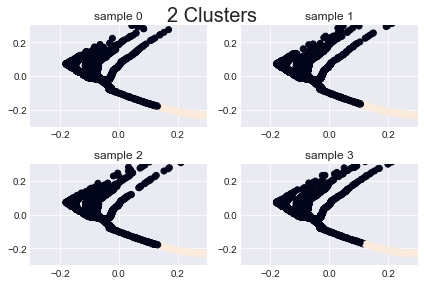

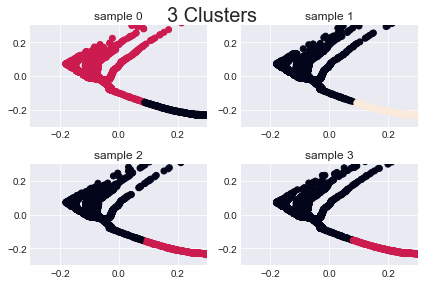

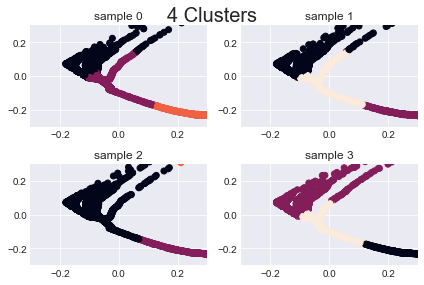

In [11]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [12]:
for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.7307374718891846
0.7339685029007539
0.7361788372822736
0.731116782644572


# Analysis 

- All four samples performed in a similar fashion given the differences in the amount of clusters. 
- Silhouette scores are also relatively the same which means that the results are at least consistent. 

# Mean Shift Model

In [13]:
# Initialize new data frames
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['cluster_pred','mean_shift', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3, 0.4]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        # Ensuring all sets are the same lenght
        data = data[:4013][:]
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms['clust' + str(cntrs) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'cluster_pred':'clust' + str(cntrs) + '_sample' + str(counter), 
                              'silhouette_score':sscore, 'quantile':n}, ignore_index=True)

In [14]:
score_ms.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,mean_shift,quantile,silhouette_score
11,clust3_sample2,NaN,0.4,0.745519
7,clust3_sample1,NaN,0.4,0.743787
9,clust4_sample2,NaN,0.2,0.741182
2,clust6_sample0,NaN,0.3,0.740336
10,clust5_sample2,NaN,0.3,0.738940
13,clust3_sample3,NaN,0.2,0.738923
3,clust6_sample0,NaN,0.4,0.737986
1,clust6_sample0,NaN,0.2,0.735808
5,clust6_sample1,NaN,0.2,0.734659
15,clust5_sample3,NaN,0.4,0.734377


# Analysis

- Set up different quantiles that could be used in the meanshift but the performance is still similar to the kmeans. 
- Having the biggest quantile as the parameter gives the best score. 

# Spectral Clustering

In [15]:
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore_sc}, ignore_index=True)

In [16]:
score_sc.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,silhouette_score
1,clust3_sample0,0.746752
5,clust3_sample1,0.746115
9,clust3_sample2,0.745379
13,clust3_sample3,0.741197
8,clust2_sample2,0.734973
4,clust2_sample1,0.732329
12,clust2_sample3,0.729987
0,clust2_sample0,0.729093
10,clust4_sample2,0.723482
2,clust4_sample0,0.717269


# Analysis

- Accuracy hasn't changed compared to previous model.
- All three models so far seem to do the best when there are three clusters suggesting that there are three main features that are descriptive of the runners. 

# Affinity Propagation

In [26]:
# Initialize data frames
ypred = pd.DataFrame()
score_af = pd.DataFrame(columns=['cluster_pred','AF'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Ensuring all sets are the same lenght
    data = data[:4013][:]
    # Instantiating and fit_predicting model to then add to data frame
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    #pred = af.fit_predict(data)
    #ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
    # Calculating silhouette scores for the data and adding that to the shilouette score
    labels = af.labels_
    sscore_af = metrics.silhouette_score(data, labels, metric='euclidean')
    score_af = score_af.append({'cluster_pred':'clust' + str(n_clusters_) + '_sample' + str(counter), 
                              'AF':sscore_af}, ignore_index=True)

In [27]:
score_af.sort_values(by='AF', ascending=False)

,cluster_pred,AF
2,clust2215_sample2,0.160370
1,clust2182_sample1,0.148172
0,clust2685_sample0,0.124780
3,clust3091_sample3,0.083818


# Analysis

Affinity propagation didn't do well this time. It needed a bunch of clusters but the s-score is even worse than before.

# Conclusion

Overall, spectral and mean shift both did the best with 74% accuracy. Both of the top results needed 3 clusters which suggest that there are three main group of runners in the marathon. I will now see what the main groups were in the K Means model.

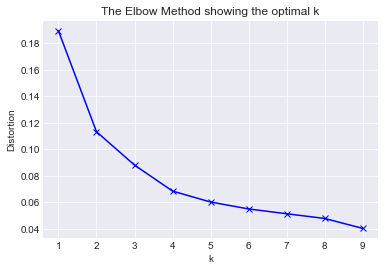

In [18]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X1)
    kmeanModel.fit(X1)
    distortions.append(sum(np.min(cdist(X1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X1.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

3 clusters are the optimal amount of clusters because we see that if a 4th cluster is added, the SSE or distortion will only drop .02 which isn't as good. Although the elbow is more at 2 clusters, there is still a significant drop of .06 so 3 clusters is the optimal amount of clusters to lower the sum of squared errors.

In [22]:
cluster_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)
X_pred = X.copy()
X_pred['cluster_assignment'] = cluster_pred

cluster_dataframes = {}
for n_clust in range(3):
    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

for name, frame in cluster_dataframes.items():
    print(name)
    print('\n')
    print(frame.describe())

0


               25k          age     division          10k       gender  \
count  5493.000000  5493.000000  5493.000000  5493.000000  5493.000000   
mean    120.126461    41.894411  1125.778809    47.639370     0.511742   
std       5.123305    10.026647   814.023473     2.384096     0.499908   
min      94.300000    18.000000     1.000000    36.780000     0.000000   
25%     116.950000    35.000000   461.000000    46.170000     0.000000   
50%     120.500000    43.000000  1012.000000    47.880000     1.000000   
75%     123.830000    50.000000  1486.000000    49.280000     1.000000   
max     135.050000    72.000000  3304.000000    56.380000     1.000000   

              half     official       overall         pace          30k  \
count  5493.000000  5493.000000   5493.000000  5493.000000  5493.000000   
mean    100.956738   210.558507   8631.976516     8.038915   145.689372   
std       4.547817     6.194792   1691.280815     0.236515     5.621314   
min      79.250000   199.1500

# Cluster Analysis 


Cluster 0
- Half of them are guys. 
- On average they run at a 8 minute pace. 
- The average age is 41, but the standard deviation in age is 10 years.
- The average placing of the group in their competitions is around 8600.

Cluster 1
- The majority of the runners are females, holding 61%.
- They run at an 8.91 minute pace, which is slightly slwoer than the previous cluster.
- This cluster has a more diverse age range where the average age is 46, but the standard deviation is also 10 years.
- On average, this group will place around 14,500.

Cluster 2
- This cluster are 86% male. 
- This a faster cluster since their pace is 6.97.
- This cluster is also younger, the average age being 37 and the standard deviation in age is 8 years. 
- Unsurprisingly, this cluster also places higher with the average rank being around 2800.

In [23]:
# run k-means on the full dataset
n_clusters = 3
km_model = KMeans(n_clusters = n_clusters, random_state = 42)
km_model.fit(X_pred)
# add labels to data for analysis
X_label = X_pred.copy()
X_label['label'] = km_model.labels_

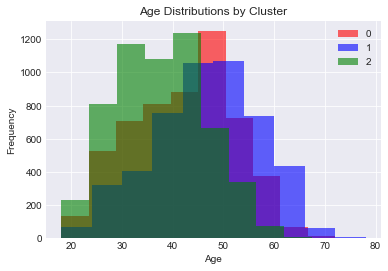

In [30]:
# look at age histograms by cluster
fig,ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green'}
grouped = X_label.groupby('label')
for key,group in grouped:
    group['age'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha = 0.6)
plt.legend()
plt.xlabel('Age')
plt.title('Age Distributions by Cluster')
plt.show()

Here we can see that the youngest people are in cluster 2 but the majority of the age range of the clusters still overlap. 

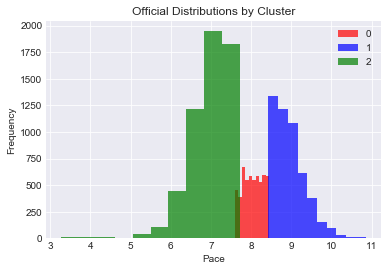

In [32]:
# look at pace histograms by cluster
fig,ax = plt.subplots()
for key,group in grouped:
    group['pace'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha = 0.7)
plt.legend()
plt.xlabel('Pace')
plt.title('Official Distributions by Cluster')
plt.show()

Here we can see that cluster 2 is the fastest with there being a few outliers that can run at a 4 or 5 minute pace. Group 1 is the slowest but that is reasonable due to the fact that they are also the slowest. 